In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from typing import Literal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [2]:

outDir = os.path.join('output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)


EPOCHS =32 # nos of epochs
ALPHA = 0.001 # learning 
TEST_SIZE = 0.2
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

plt .rcParams.update(params)

<Figure size 1500x800 with 0 Axes>

## Prevent Tensorflow from hogging the memory

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU') # tellme nos of GPUs
# if len (physical_devices) > 0:
#       tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# physical_devices

In [5]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.shape

(18207, 89)

In [6]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [8]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [9]:
cols = data_df.columns

for col in cols:
    print(f'\nColumns Name: {col} : {data_df[col].unique()}')



Columns Name: Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]

Columns Name: ID : [158023  20801 190871 ... 241638 246268 246269]

Columns Name: Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']

Columns Name: Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]

Columns Name: Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']

Columns Name: Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria

In [10]:
data_df = data_df[data_df['Position'].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [11]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Release Clause    1504
Length: 89, dtype: int64

In [12]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [13]:
# keeping relevant columns
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  object 
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina          

In [15]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [16]:
goalkeeper = 'GK'
forward = ['RF', 'ST', 'LW', 'LF', 'RS', 'CF', 'LS', 'RW']
midfielder = ['CM','RCM','LCM','CDM','RDM','LDM', 'CAM', 'LAM','RAM','RM','LM']
defender = ['CB','LCB','RCB','RWB', 'LWB','RB', 'LB']

In [17]:
len(data_df['Position'].unique()) - len(forward) - len(midfielder) - len(defender)

1

In [18]:
# Assign labels to goalkeepers
data_df.loc[data_df['Position'] == 'GK','Position'] = 0

# Defenders
data_df.loc[data_df['Position'].isin(defender),'Position'] = 1

#Midfielders
data_df.loc[data_df['Position'].isin(midfielder),'Position'] = 2

#Forwards
data_df.loc[data_df['Position'].isin(forward),'Position'] = 3

# Assist Pandas in data conversion

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast = 'integer')

In [19]:
labels_dic = {0: 'Goalkeepers',1:'Defender', 2: 'Midfielder', 3: 'Forward'}

In [20]:
features_df = data_df.drop('Position', axis = 1)
labels = data_df.Position

In [21]:
X_train,X_test,y_train,y_test = train_test_split(features_df,labels,
                                                test_size = TEST_SIZE,
                                                stratify = labels,
                                                random_state = RANDOM_STATE)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [22]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)


In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(18, activation = 'relu'),
    tf.keras.layers.Dense(4) # no activation here
])

In [24]:
X_train[:,1].shape

(14517,)

In [25]:
prediction = model(X_train[:1]).numpy()
prediction.sum()

1.0826722

In [26]:
tf.nn.softmax(prediction).numpy().sum()

1.0

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (1, 18)                     │             612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 4)                      │              76 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
(33*18)+18

612

In [29]:
(18*4)+4

76

In [30]:
612+76

688

In [31]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True )

In [32]:
y_train[:1].to_numpy()

array([3], dtype=int8)

In [33]:
loss_fn(y_train[:1],prediction).numpy()

1.7177732

In [34]:
model.compile(optimizer = 'Adam',loss = loss_fn,metrics = ['accuracy'])

### Training our model

In [35]:
history = model.fit(X_train,y_train,
                     validation_data =[X_test,y_test],
                     batch_size = BATCH_SIZE,
                     epochs = EPOCHS)

Epoch 1/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.6135 - loss: 0.8633 - val_accuracy: 0.8435 - val_loss: 0.3806
Epoch 2/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.8589 - loss: 0.3519 - val_accuracy: 0.8529 - val_loss: 0.3345
Epoch 3/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.8672 - loss: 0.3163 - val_accuracy: 0.8592 - val_loss: 0.3204
Epoch 4/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8737 - loss: 0.3042 - val_accuracy: 0.8650 - val_loss: 0.3141
Epoch 5/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.8795 - loss: 0.2955 - val_accuracy: 0.8711 - val_loss: 0.3088
Epoch 6/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.8790 - loss: 0.2907 - val_accuracy: 0.8683 - val_loss: 0.3075
Epoch 7/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.8735 - loss: 0.3000 - val_accuracy: 0.8702 - val_loss: 0.3049
Epoch 8/32
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8852 - loss: 0.2859 - 

In [36]:
model.evaluate(X_test,y_test, verbose = 2)

114/114 - 0s - 605us/step - accuracy: 0.8749 - loss: 0.2998


[0.2997881770133972, 0.8749311566352844]

In [37]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.763588,0.579244,0.843526,0.380578
1,0.860784,0.342195,0.852893,0.334543
2,0.870497,0.316670,0.859229,0.320372
3,0.874699,0.305369,0.865014,0.314093
4,0.879658,0.299436,0.871074,0.308843


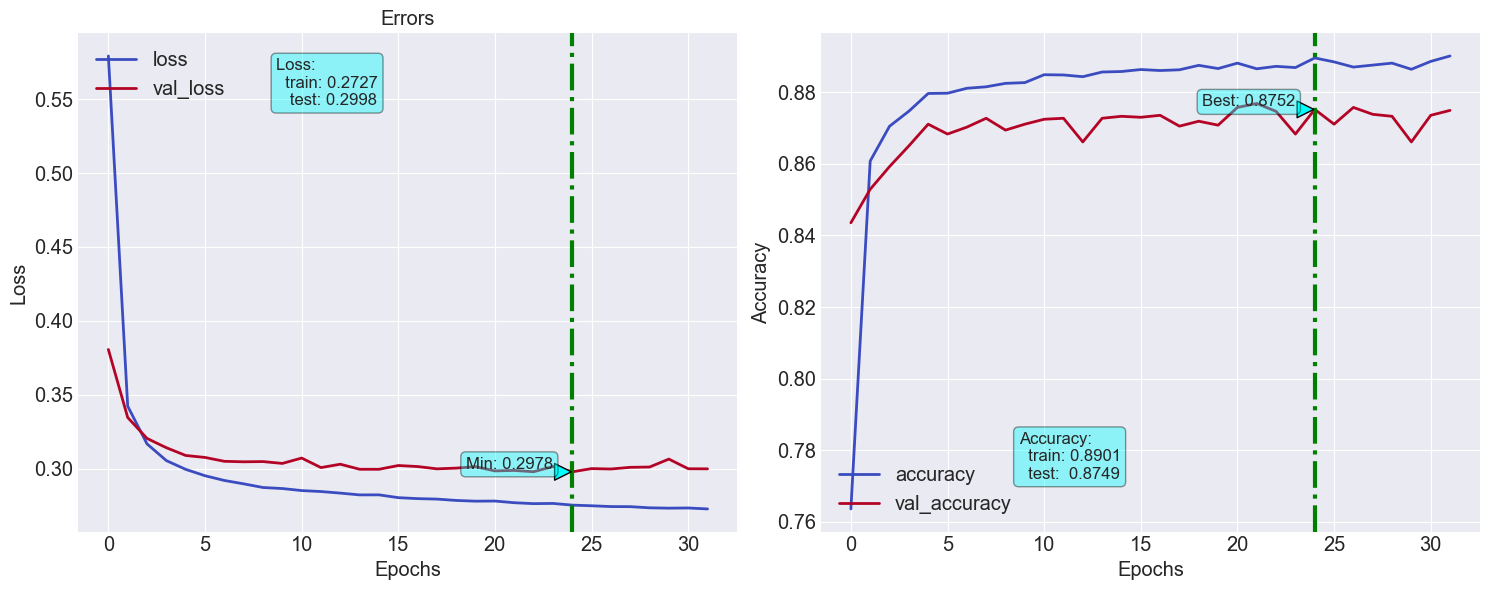

In [38]:
fn_plot_tf_hist(loss_df)

In [39]:
y_logits = model(X_train)
y_pred1 = tf.nn.softmax(y_logits).numpy()

In [40]:
y_pred1

array([[3.1364742e-09, 5.9706758e-07, 4.3409910e-02, 9.5658952e-01],
       [8.2854001e-10, 7.3003307e-06, 7.8110814e-01, 2.1888448e-01],
       [1.6948781e-09, 6.8136469e-05, 7.7691132e-01, 2.2302061e-01],
       ...,
       [9.9999857e-01, 3.7989023e-10, 1.7355775e-08, 1.4300226e-06],
       [9.9999952e-01, 9.6480463e-12, 2.8414558e-08, 5.1286219e-07],
       [9.9999988e-01, 7.5878138e-13, 7.9494400e-10, 8.1180602e-08]],
      dtype=float32)

In [41]:
pred_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [42]:
y_pred = pred_model(X_train).numpy()
y_pred

array([[3.1364742e-09, 5.9706758e-07, 4.3409910e-02, 9.5658952e-01],
       [8.2854001e-10, 7.3003307e-06, 7.8110814e-01, 2.1888448e-01],
       [1.6948781e-09, 6.8136469e-05, 7.7691132e-01, 2.2302061e-01],
       ...,
       [9.9999857e-01, 3.7989023e-10, 1.7355775e-08, 1.4300226e-06],
       [9.9999952e-01, 9.6480463e-12, 2.8414558e-08, 5.1286219e-07],
       [9.9999988e-01, 7.5878138e-13, 7.9494400e-10, 8.1180602e-08]],
      dtype=float32)

In [43]:
print(classification_report(y_train, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.92      0.93      4693
           2       0.84      0.88      0.86      5470
           3       0.87      0.79      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



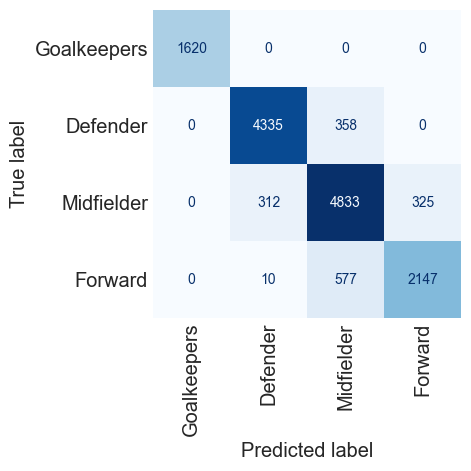

In [44]:
fn_plot_confusion_matrix(y_train, y_pred.argmax(axis=1), labels_dic)

In [45]:
y_logits = model(X_test)
y_pred2 = tf.nn.softmax(y_logits).numpy()

In [46]:
y_pred2

array([[7.4560622e-11, 3.9740703e-06, 4.9013194e-01, 5.0986415e-01],
       [8.8463770e-10, 8.2183797e-06, 7.7624512e-01, 2.2374669e-01],
       [3.2583674e-08, 4.1474329e-04, 2.7903220e-01, 7.2055304e-01],
       ...,
       [1.0021490e-07, 3.7093405e-02, 9.4775724e-01, 1.5149226e-02],
       [3.1504212e-07, 1.4526856e-03, 9.2627400e-01, 7.2272994e-02],
       [2.4284248e-07, 6.3662583e-01, 3.6331633e-01, 5.7566151e-05]],
      dtype=float32)

In [47]:
y_pred = pred_model(X_test).numpy()
y_pred

array([[7.4560622e-11, 3.9740703e-06, 4.9013194e-01, 5.0986415e-01],
       [8.8463770e-10, 8.2183797e-06, 7.7624512e-01, 2.2374669e-01],
       [3.2583674e-08, 4.1474329e-04, 2.7903220e-01, 7.2055304e-01],
       ...,
       [1.0021490e-07, 3.7093405e-02, 9.4775724e-01, 1.5149226e-02],
       [3.1504212e-07, 1.4526856e-03, 9.2627400e-01, 7.2272994e-02],
       [2.4284248e-07, 6.3662583e-01, 3.6331633e-01, 5.7566151e-05]],
      dtype=float32)

In [48]:
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.87      0.84      1368
           3       0.84      0.74      0.78       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.88      0.87      0.87      3630



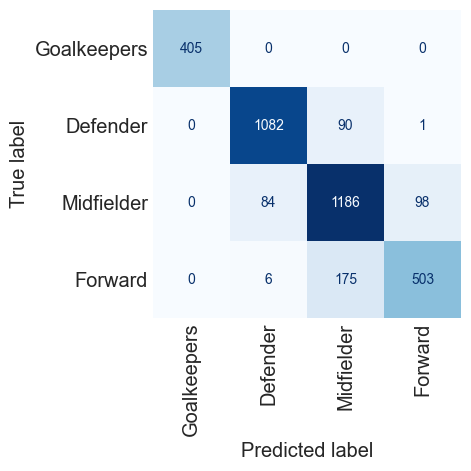

In [49]:
fn_plot_confusion_matrix(y_test, y_pred.argmax(axis=1), labels_dic)

In [50]:
tf.__version__

'2.16.1'